# Imports and Hyperparameters

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
dataset_size= 160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


# 1 Data

In [2]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-12-15 05:28:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c09::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   286MB/s    in 0.8s    

2020-12-15 05:28:58 (286 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [3]:
num_sentences = 0
with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
      list_item=[]
      
      list_item.append(row[5])
      
      if row[0] == '0':
        list_item.append(0)
      else:
        list_item.append(1)

      num_sentences = num_sentences + 1
      corpus.append(list_item)


In [4]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [ ]:
# original code but I have an issue with this. This may cause data leakage.

#sentences=[]
#labels=[]
#random.shuffle(corpus)
#for x in range(training_size):
#    sentences.append(corpus[x][0])
#    labels.append(corpus[x][1])
#
#
#tokenizer = Tokenizer(oov_token=oov_tok)
#tokenizer.fit_on_texts(sentences)
#
#word_index = tokenizer.word_index
#vocab_size=len(word_index)
#
#sequences = tokenizer.texts_to_sequences(sentences)
#padded = pad_sequences(sequences)
#
#split = int(test_portion * training_size)
#
#test_sequences = padded[0:split]
#training_sequences = padded[split:training_size]
#test_labels = labels[0:split]
#training_labels = labels[split:training_size]

In [5]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(dataset_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

split = int(test_portion * dataset_size)
train_sentences = sentences[split:dataset_size]
train_labels = labels[split:dataset_size]
test_sentences = sentences[0:split]
test_labels = labels[0:split]

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

train_seq = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)


training_padded = np.array(train_padded)
training_labels = np.array(train_labels)

testing_padded = np.array(test_padded)
testing_labels = np.array(test_labels)

def get_vocabsize(sentences):
  tokenizer_temp = Tokenizer()
  tokenizer_temp.fit_on_texts(sentences)

  word_index = tokenizer_temp.word_index
  vocab_size=len(word_index)

  return vocab_size, word_index
vocab_size, word_index = get_vocabsize(sentences)

In [6]:
print(vocab_size)
print(word_index['i'])

138947
1


# *2 Get Embeddings from GloVe

In [7]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
    
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-12-15 05:29:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.20.128, 74.125.28.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   147MB/s    in 2.2s    

2020-12-15 05:29:18 (147 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [8]:
print(len(embeddings_matrix))

138948


# 3 Model

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13894800  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,959,953
Trainable params: 65,153
Non-trainable params: 13,894,800
_______________________________________

# 4 Plot Accuracy and Loss

<Figure size 432x288 with 0 Axes>

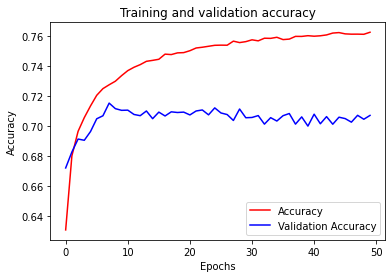

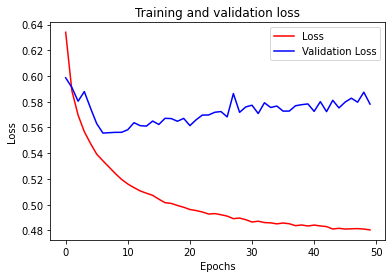

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!